In [31]:
import pickle
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.experimental import enable_halving_search_cv
from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    cross_val_predict,
    RandomizedSearchCV,
    HalvingRandomSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)
from xgboost import XGBClassifier
from pathlib import Path
import category_encoders as ce
import optuna
from pycaret.classification import load_model, ClassificationExperiment
from mlutils.classification import classifier_param_grid,classifier_plots

In [2]:
SEED = 1990
MODEL_REPO = 'models/'

### Read Data

In [3]:
with open('classification_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['dataset', 'X_train', 'X_test', 'y_train', 'y_test', 'train', 'test'])

In [4]:
train, test = data['train'], data['test']

In [5]:
test.target.value_counts(normalize=True)

0    0.7
1    0.3
Name: target, dtype: float64

### Load ready-to-serve pipeline

In [9]:
e1 = ClassificationExperiment()

In [11]:
e1.setup(data=train,
          test_data=test,
          preprocess=False,
          fold_strategy='stratifiedkfold',
          fold=10,
          session_id=SEED,
          experiment_name="custom_model"
          )

,Description,Value
0,Session id,1990
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 8)"
4,Transformed data shape,"(1000, 8)"
5,Transformed train set shape,"(750, 8)"
6,Transformed test set shape,"(250, 8)"
7,Numeric features,5
8,Categorical features,2


In [15]:
params_grid = {
    "clf__n_estimators": [100, 150, 200],
    "clf__learning_rate": [0.01, 0.1, 0.5],
    "clf__max_depth": [3, 5, 7],
    "clf__min_child_weight": [1, 3, 5],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0.1, 0.3, 0.5],
    "clf__reg_alpha": [0.1, 0.25, 0.75],
#     "clf__reg_lambda": [0.1, 0.25, 0.75],
}

In [16]:
pretrained = e1.load_model(f'{MODEL_REPO}modelfit')

Transformation Pipeline and Model Successfully Loaded


In [17]:
tuned1 = e1.tune_model(pretrained,
                       custom_grid = params_grid,
                       n_iter = 20,
                       search_library = 'scikit-learn',
                       search_algorithm = 'random', 
                       return_train_score = True)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [18]:
tuned2 = e1.tune_model(pretrained,
                       custom_grid = params_grid,
                       n_iter = 20,
                       search_library = 'optuna',
                       search_algorithm = 'tpe', 
                       return_train_score = True)

[I 2023-04-23 06:27:55,462] Searching the best hyperparameters using 750 samples...
[I 2023-04-23 06:28:54,262] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [51]:
tuned2.named_steps['clf'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.6,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [24]:
tuned2.named_steps['clf']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

### Load trained pipelines

In [6]:
e2 = ClassificationExperiment()

In [7]:
e2.setup(
    data=train,
    test_data=test,
    preprocess=False,
    fold_strategy='stratifiedkfold',
    fold=10,
    session_id=SEED,
    experiment_name="loaded_pipelines"
)

,Description,Value
0,Session id,1990
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 8)"
4,Transformed data shape,"(1000, 8)"
5,Transformed train set shape,"(750, 8)"
6,Transformed test set shape,"(250, 8)"
7,Numeric features,5
8,Categorical features,2


In [8]:
# covert string path into Path
model_repo = Path(MODEL_REPO)
print(model_repo)

# capture all models of a certain pattern
model_repo_list = list(model_repo.glob('*pipe_*'))
model_repo_list_no_suffix = [str(x).replace(".pkl","") for x in model_repo_list]
model_repo_list_no_suffix

models


['models/pipe_LGBMClassifier',
 'models/pipe_XGBClassifier',
 'models/pipe_KNeighborsClassifier',
 'models/pipe_LogisticRegression',
 'models/pipe_RandomForestClassifier',
 'models/pipe_GradientBoostingClassifier',
 'models/pipe_AdaBoostClassifier']

In [9]:
loaded_models = [e2.load_model(x) for x in model_repo_list_no_suffix]
loaded_models

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


[Pipeline(memory=None,
          steps=[('prp',
                  ColumnTransformer(n_jobs=None, remainder='drop',
                                    sparse_threshold=0.3,
                                    transformer_weights=None,
                                    transformers=[('num',
                                                   Pipeline(memory=None,
                                                            steps=[('numeric',
                                                                    StandardScaler(copy=True,
                                                                                   with_mean=True,
                                                                                   with_std=True))],
                                                            verbose=False),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x1054ba790>),
                                                  (

In [21]:
tuned_models = []
for lm in loaded_models:

    temp_clf_name = lm.steps[-1][0]    
    temp_grid = classifier_param_grid(lm)
    temp_clf_grid = {f"{temp_clf_name}__k":v for k,v in temp_grid.items()}
    
    temp_tuned_model = e2.tune_model(lm,
                                     custom_grid = temp_clf_grid,
                                     n_iter = 20,
                                     search_library = 'optuna',
                                     search_algorithm = 'tpe', 
                                     return_train_score = True)
    
    tuned_models.append(temp_tuned_model)
    

[I 2023-04-23 19:40:52,444] Searching the best hyperparameters using 750 samples...


[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown parameter: k
[LightGBM] [Warning] Unknown param

[I 2023-04-23 19:41:37,325] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


[I 2023-04-23 19:41:42,804] Searching the best hyperparameters using 750 samples...
[19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:41:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:41:42] WARNING: /Users/runner/work/xgboost

[19:42:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:42:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:42:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "k" } are not used.

[19:42:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:42:40
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


[I 2023-04-23 19:42:40,873] Searching the best hyperparameters using 750 samples...
[W 2023-04-23 19:42:40,880] Trial 1 failed with parameters: {'actual_estimator__KNeighborsClassifier__k': 1} because of the following error: ValueError("Invalid parameter 'actual_estimator' for estimator Pipeline(steps=[('prp',\n                 ColumnTransformer(transformers=[('num',\n                                                  Pipeline(steps=[('numeric',\n                                                                   StandardScaler())]),\n                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c609310>),\n                                                 ('cat',\n                                                  Pipeline(steps=[('categorical',\n                                                                   CatBoostEncoder())]),\n                                                  <sklearn.compose._column_transformer.make_colu

[W 2023-04-23 19:42:40,891] Trial 2 failed with parameters: {'actual_estimator__KNeighborsClassifier__k': 2} because of the following error: ValueError("Invalid parameter 'actual_estimator' for estimator Pipeline(steps=[('prp',\n                 ColumnTransformer(transformers=[('num',\n                                                  Pipeline(steps=[('numeric',\n                                                                   StandardScaler())]),\n                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16d137730>),\n                                                 ('cat',\n                                                  Pipeline(steps=[('categorical',\n                                                                   CatBoostEncoder())]),\n                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16d1373a0>)])),\n                ('KNeighborsClassifier', KN

[W 2023-04-23 19:42:40,905] Trial 5 failed with parameters: {'actual_estimator__KNeighborsClassifier__k': 2} because of the following error: ValueError("Invalid parameter 'actual_estimator' for estimator Pipeline(steps=[('prp',\n                 ColumnTransformer(transformers=[('num',\n                                                  Pipeline(steps=[('numeric',\n                                                                   StandardScaler())]),\n                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c73adc0>),\n                                                 ('cat',\n                                                  Pipeline(steps=[('categorical',\n                                                                   CatBoostEncoder())]),\n                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c73a2e0>)])),\n                ('KNeighborsClassifier', KN

[W 2023-04-23 19:42:40,915] Trial 6 failed with parameters: {'actual_estimator__KNeighborsClassifier__k': 1} because of the following error: ValueError("Invalid parameter 'actual_estimator' for estimator Pipeline(steps=[('prp',\n                 ColumnTransformer(transformers=[('num',\n                                                  Pipeline(steps=[('numeric',\n                                                                   StandardScaler())]),\n                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cc9c790>),\n                                                 ('cat',\n                                                  Pipeline(steps=[('categorical',\n                                                                   CatBoostEncoder())]),\n                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16cc9c340>)])),\n                ('KNeighborsClassifier', KN

[W 2023-04-23 19:42:40,922] Trial 1 failed with value None.
[W 2023-04-23 19:42:40,923] Trial 0 failed with value None.
[W 2023-04-23 19:42:40,923] Trial 2 failed with value None.
[W 2023-04-23 19:42:40,924] Trial 3 failed with value None.
[W 2023-04-23 19:42:40,925] Trial 5 failed with value None.
[W 2023-04-23 19:42:40,925] Trial 4 failed with value None.
[W 2023-04-23 19:42:40,926] Trial 6 failed with value None.
[W 2023-04-23 19:42:40,926] Trial 7 failed with value None.


ValueError: Invalid parameter 'actual_estimator' for estimator Pipeline(steps=[('prp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c609310>),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical',
                                                                   CatBoostEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16c6093d0>)])),
                ('KNeighborsClassifier', KNeighborsClassifier())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [24]:
len(tuned_models)

2

In [26]:
blender = e2.blend_models(tuned_models,
#                           choose_better=True,
                          return_train_score=True)

In [29]:
blender

VotingClassifier(estimators=[('Light Gradient Boosting Machine',
                              Pipeline(memory=None,
                                       steps=[('prp',
                                               ColumnTransformer(n_jobs=None,
                                                                 remainder='drop',
                                                                 sparse_threshold=0.3,
                                                                 transformer_weights=None,
                                                                 transformers=[('num',
                                                                                Pipeline(memory=None,
                                                                                         steps=[('numeric',
                                                                                                 StandardScaler(copy=True,
                                                                                                                with_mean=True,
                                                                                                                with_std=True))],
                                                                                         verbose=False),
                                                                                <sklearn.compose._column_tran...
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             objective='binary:logistic',
                                                             predictor=None, ...))],
                                       verbose=False))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=None)

In [27]:
stacker = e2.stack_models(tuned_models,
#                           choose_better=True,
                          return_train_score=True
                         )

In [28]:
stacker

StackingClassifier(cv=5,
                   estimators=[('Light Gradient Boosting Machine',
                                Pipeline(memory=None,
                                         steps=[('prp',
                                                 ColumnTransformer(n_jobs=None,
                                                                   remainder='drop',
                                                                   sparse_threshold=0.3,
                                                                   transformer_weights=None,
                                                                   transformers=[('num',
                                                                                  Pipeline(memory=None,
                                                                                           steps=[('numeric',
                                                                                                   StandardScaler(copy=True,
                                                                                                                  with_mean=True,
                                                                                                                  with_std=True))],
                                                                                           verbose=False),
                                                                                  <sklearn.compose._colu...
                                                               predictor=None, ...))],
                                         verbose=False))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=1990,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=-1, passthrough=False, stack_method='auto',
                   verbose=0)

In [54]:
y_train_prediction = e2.predict_model(stacker,data=train)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [52]:
y_test_prediction = e2.predict_model(stacker)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9000,0.9627,0.8133,0.8472,0.8299,0.7592,0.7595


In [59]:
y_train = y_train_prediction['target']
y_train_pred = y_train_prediction['prediction_score']
train_probas = pd.DataFrame({0:y_train_pred,1:1-y_train_pred}).values

y_test = y_test_prediction['target']
y_test_pred = y_test_prediction['prediction_score']
test_probas = pd.DataFrame({0:y_test_pred,1:1-y_test_pred}).values

{'confmat': <Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>,
 'roc': <Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 'pr': <Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>,
 'cal': <Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>,
 'ks': <Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>,
 'lift': <Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>,
 'gains': <Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>}

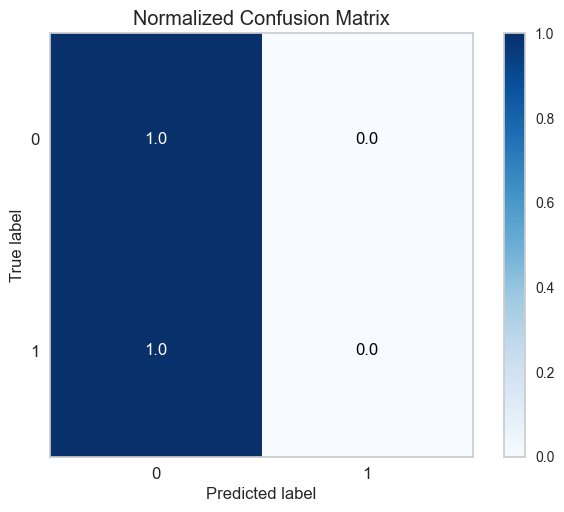

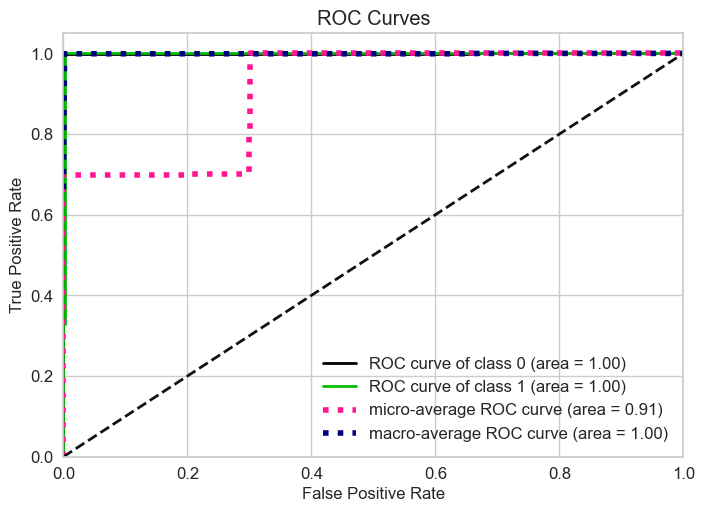

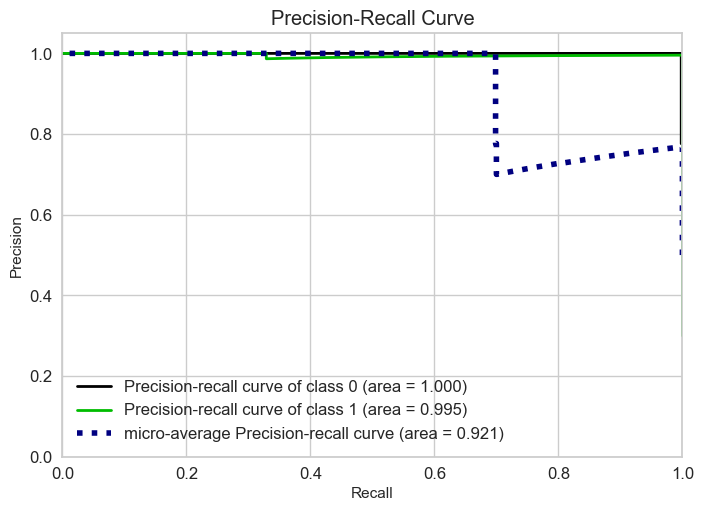

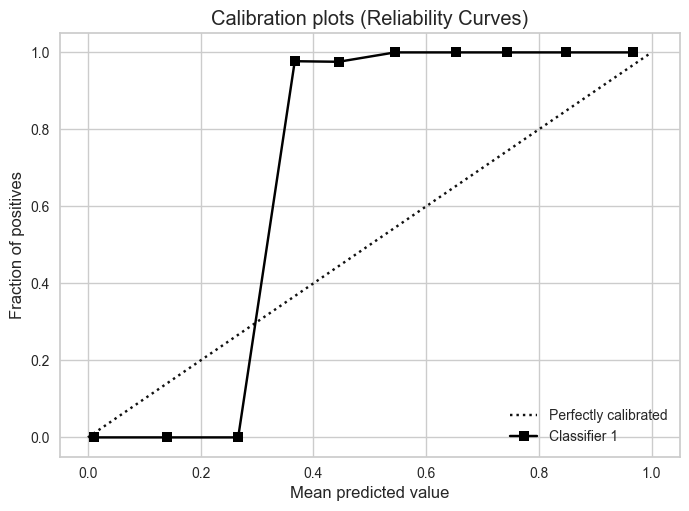

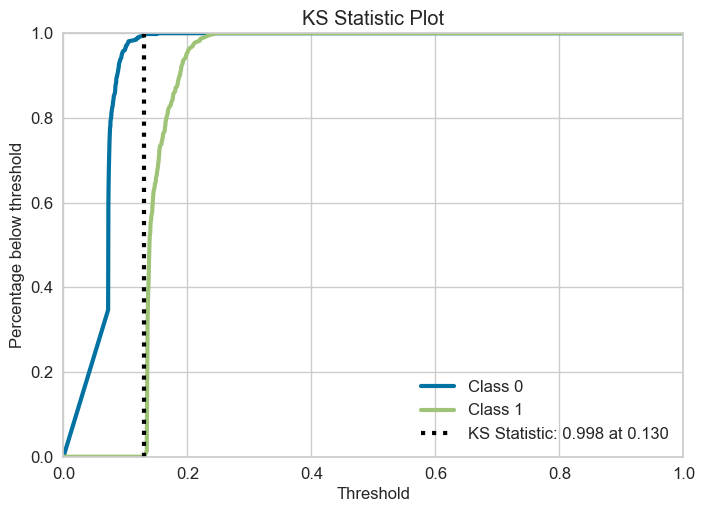

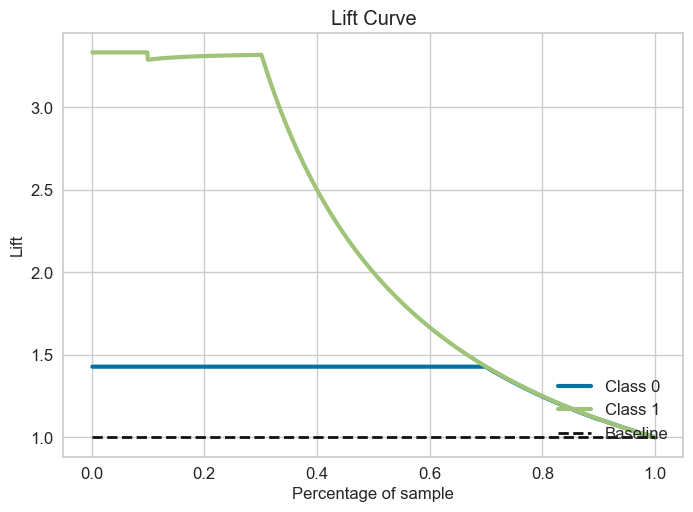

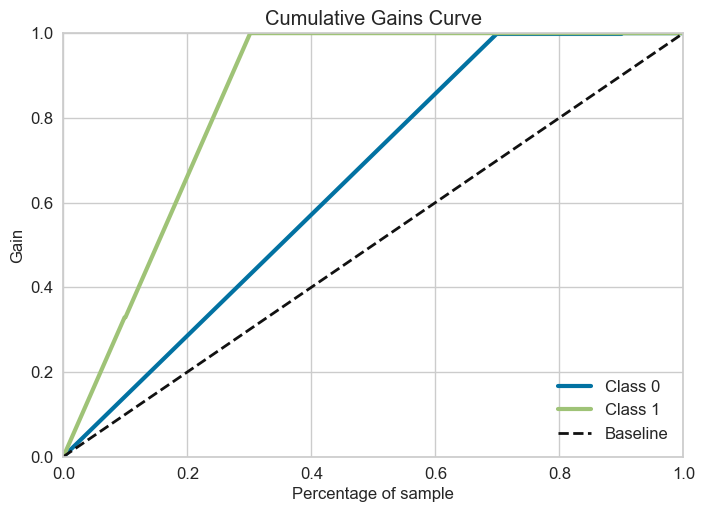

In [57]:
classifier_plots(y_train,train_probas)

{'confmat': <Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>,
 'roc': <Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 'pr': <Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>,
 'cal': <Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>,
 'ks': <Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>,
 'lift': <Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>,
 'gains': <Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>}

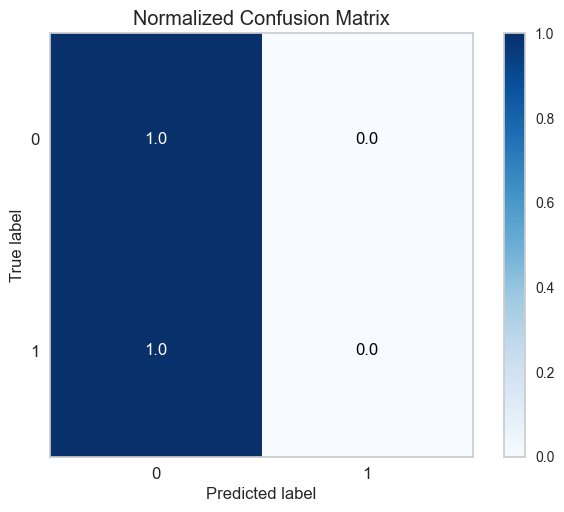

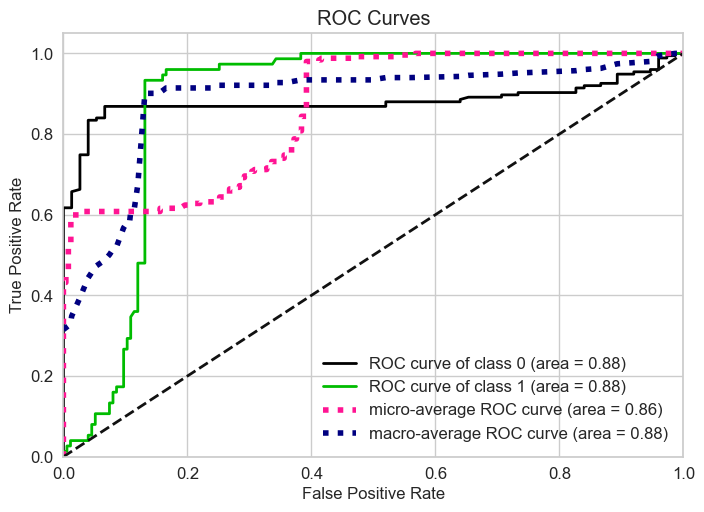

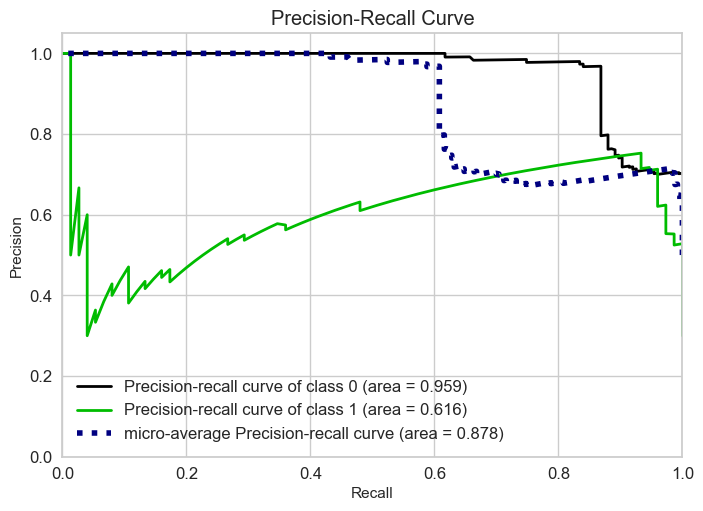

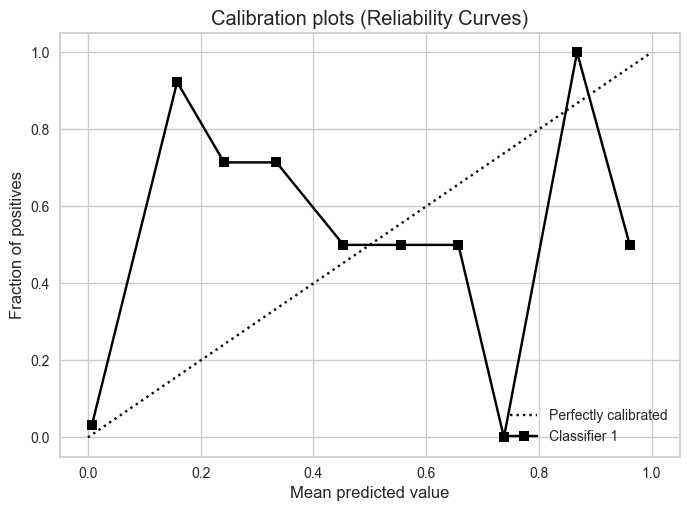

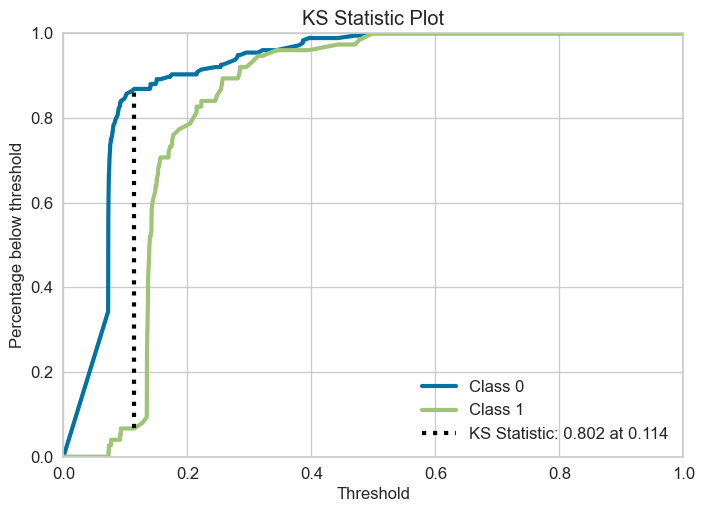

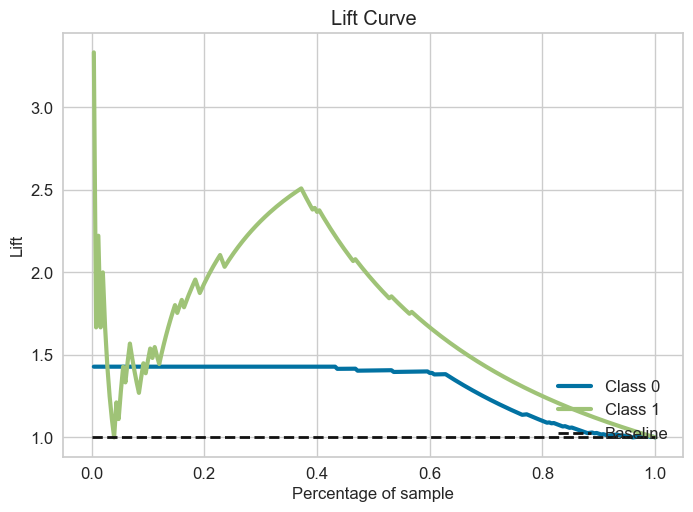

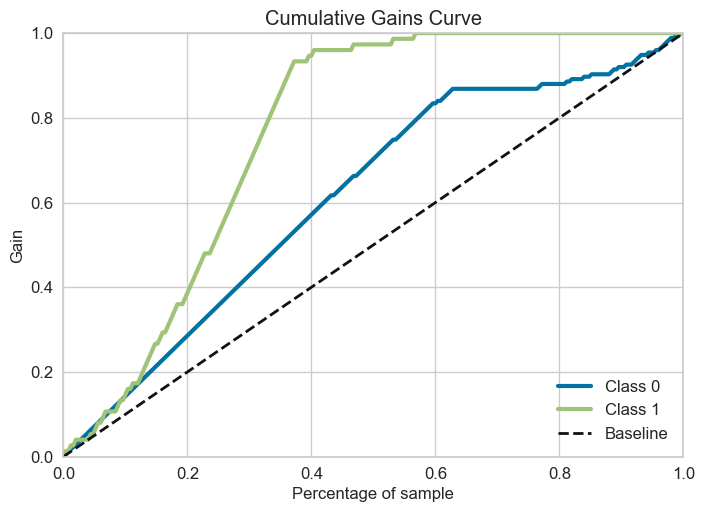

In [60]:
classifier_plots(y_test,test_probas)

In [62]:
calibrated_model = e2.calibrate_model(stacker, return_train_score=True)

In [63]:
y_train_prediction = e2.predict_model(calibrated_model,data=train)
y_test_prediction = e2.predict_model(calibrated_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9080,0.9641,0.8000,0.8824,0.8392,0.7750,0.7768


In [64]:
y_train = y_train_prediction['target']
y_train_pred = y_train_prediction['prediction_score']
train_probas = pd.DataFrame({0:y_train_pred,1:1-y_train_pred}).values

y_test = y_test_prediction['target']
y_test_pred = y_test_prediction['prediction_score']
test_probas = pd.DataFrame({0:y_test_pred,1:1-y_test_pred}).values

{'confmat': <Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>,
 'roc': <Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 'pr': <Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>,
 'cal': <Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>,
 'ks': <Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>,
 'lift': <Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>,
 'gains': <Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>}

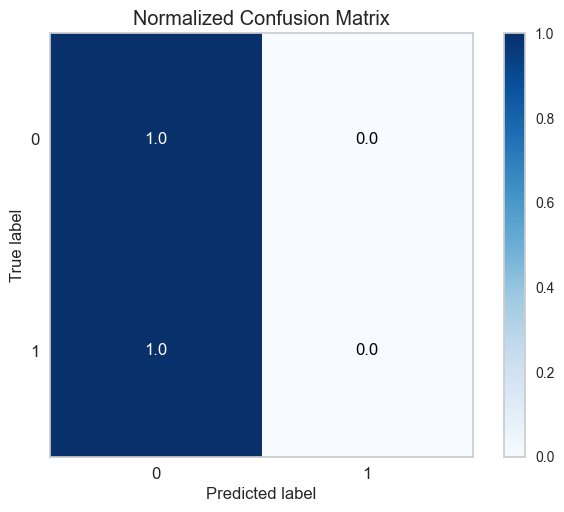

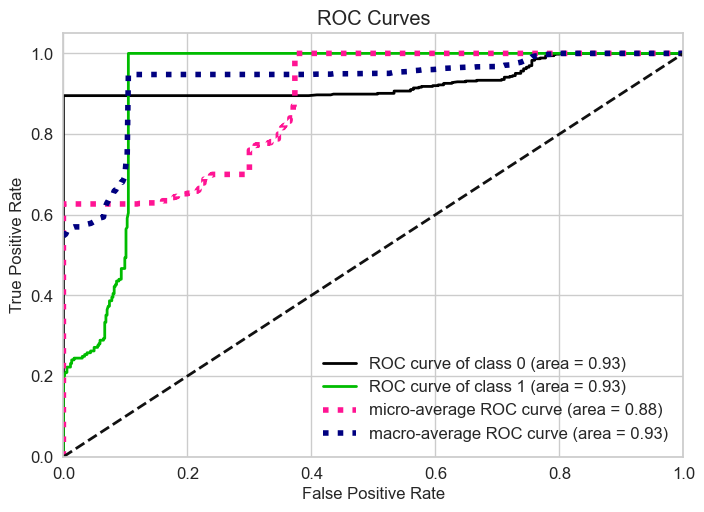

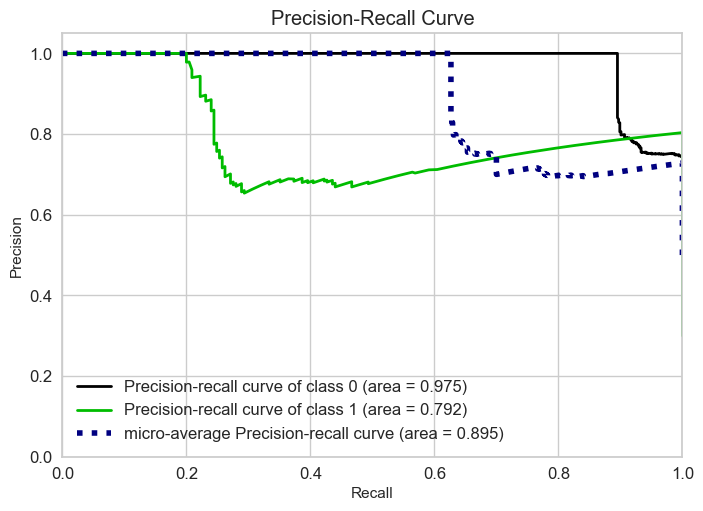

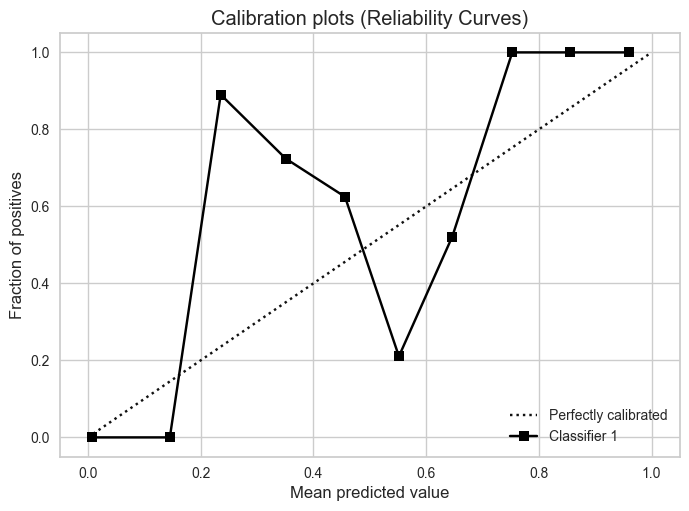

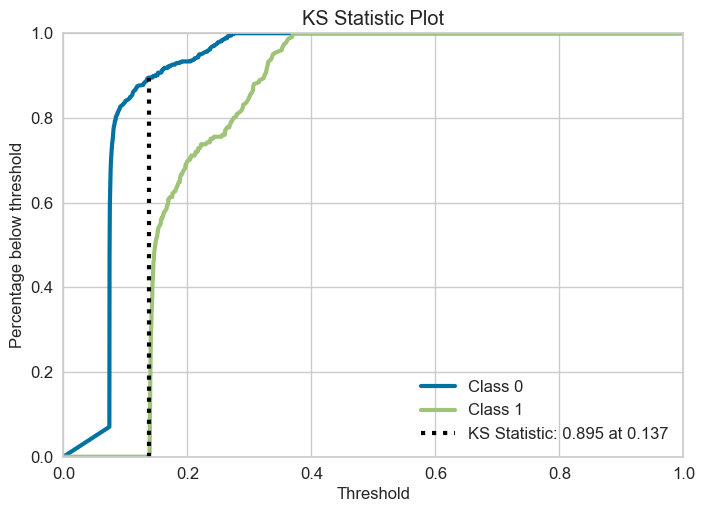

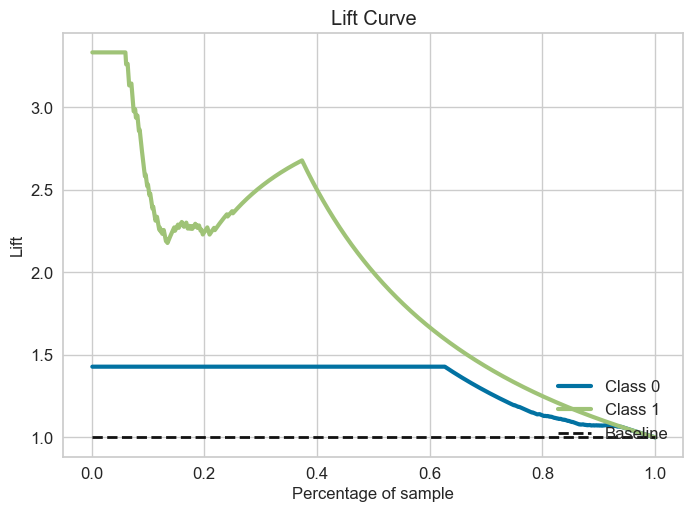

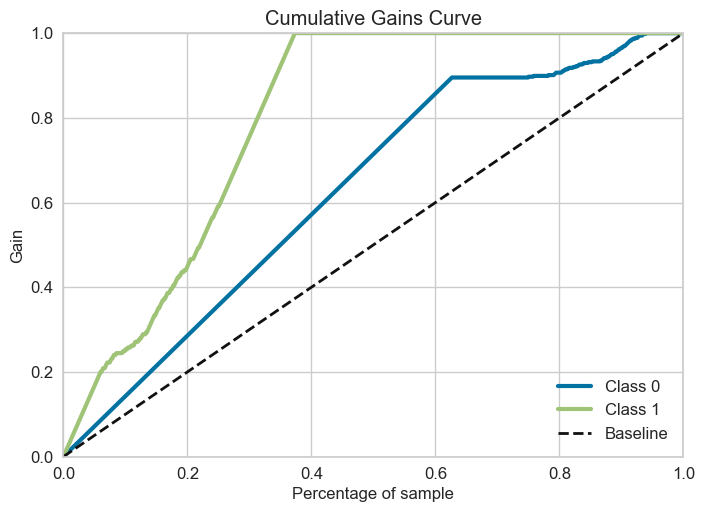

In [65]:
classifier_plots(y_train,train_probas)

### Load configured preprocessors

In [21]:
fitted_prepro = fitted_model.named_steps['prp']
fitted_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('numeric',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28586c7f0>),
                                ('cat',
                                 Pipeline(steps=[('categorical',
                                                  CatBoostEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28586c9d0>)])

In [22]:
e3 = Classificatione3eriment()

In [25]:
e3.setup(data=train,
          test_data=test,
          preprocess=False,
          custom_pipeline=[fitted_prepro],
          fold_strategy='stratifiedkfold',
          fold=10,
          session_id=SEED,
          e3eriment_name="custom_prepro"
          )

,Description,Value
0,Session id,1990
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 8)"
4,Transformed data shape,"(1000, 6)"
5,Transformed train set shape,"(750, 6)"
6,Transformed test set shape,"(250, 6)"
7,Numeric features,5
8,Categorical features,2


In [26]:
n_select = e3.models().shape[0]
print(f'{n_select=}')
e3.models()

n_select=18


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [27]:
modelboard = e3.compare_models(n_select=n_select)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8800,0.9399,0.7779,0.8208,0.7961,0.7113,0.7141,0.0800
et,Extra Trees Classifier,0.8800,0.9448,0.7686,0.8250,0.7936,0.7093,0.7120,0.0790
knn,K Neighbors Classifier,0.8680,0.9381,0.7419,0.8079,0.7720,0.6793,0.6818,0.0760
gbc,Gradient Boosting Classifier,0.8667,0.9411,0.7330,0.8092,0.7675,0.6744,0.6774,0.0730
lightgbm,Light Gradient Boosting Machine,0.8667,0.9396,0.7597,0.7952,0.7738,0.6795,0.6827,0.0750
xgboost,Extreme Gradient Boosting,0.8627,0.9375,0.7595,0.7875,0.7699,0.6723,0.6754,0.0720
ada,Ada Boost Classifier,0.8520,0.9294,0.7065,0.7850,0.7416,0.6384,0.6418,0.0760
dt,Decision Tree Classifier,0.8333,0.8024,0.7247,0.7270,0.7229,0.6041,0.6066,0.0680
lr,Logistic Regression,0.8227,0.9077,0.6441,0.7382,0.6854,0.5629,0.5674,0.2290
lda,Linear Discriminant Analysis,0.8227,0.9068,0.6658,0.7214,0.6915,0.5674,0.5691,0.0700


In [56]:
modelboard

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=1990, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1990, verbose=0, warm_start=False),
 KN

In [57]:
modelboarddf = e3.pull()
modelboarddf

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8800,0.9399,0.7779,0.8208,0.7961,0.7113,0.7141,0.058
et,Extra Trees Classifier,0.8800,0.9448,0.7686,0.8250,0.7936,0.7093,0.7120,0.059
knn,K Neighbors Classifier,0.8680,0.9381,0.7419,0.8079,0.7720,0.6793,0.6818,0.045
gbc,Gradient Boosting Classifier,0.8667,0.9411,0.7330,0.8092,0.7675,0.6744,0.6774,0.051
lightgbm,Light Gradient Boosting Machine,0.8667,0.9396,0.7597,0.7952,0.7738,0.6795,0.6827,0.053
xgboost,Extreme Gradient Boosting,0.8627,0.9375,0.7595,0.7875,0.7699,0.6723,0.6754,0.049
ada,Ada Boost Classifier,0.8520,0.9294,0.7065,0.7850,0.7416,0.6384,0.6418,0.055
dt,Decision Tree Classifier,0.8333,0.8024,0.7247,0.7270,0.7229,0.6041,0.6066,0.046
lr,Logistic Regression,0.8227,0.9077,0.6441,0.7382,0.6854,0.5629,0.5674,0.183
lda,Linear Discriminant Analysis,0.8227,0.9068,0.6658,0.7214,0.6915,0.5674,0.5691,0.044


In [58]:
# ensembled_models = [e3.ensemble_model(m, choose_better=True) for m in tuned_models]

In [61]:
tuned_models = [e3.tune_model(m,
                               search_library='optuna',
                               search_algorithm='tpe'
                              ) 
                for m in modelboard[:3]]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9067,0.9849,0.7391,0.9444,0.8293,0.7664,0.7773
1,0.9067,0.9691,0.8261,0.8636,0.8444,0.7778,0.7782
2,0.8400,0.9256,0.6957,0.7619,0.7273,0.6144,0.6157
3,0.8800,0.9331,0.7391,0.8500,0.7907,0.7072,0.7106
4,0.8533,0.9172,0.7391,0.7727,0.7556,0.6509,0.6512
5,0.8933,0.9494,0.6818,0.9375,0.7895,0.7204,0.7368
6,0.8667,0.9485,0.8182,0.7500,0.7826,0.6867,0.6881
7,0.8667,0.9340,0.7273,0.8000,0.7619,0.6696,0.6711
8,0.8400,0.9211,0.6364,0.7778,0.7000,0.5924,0.5979


[I 2023-04-22 03:38:21,678] Searching the best hyperparameters using 750 samples...
[I 2023-04-22 03:38:46,912] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8933,0.9640,0.6957,0.9412,0.8000,0.7295,0.7450
1,0.8933,0.9540,0.7826,0.8571,0.8182,0.7429,0.7445
2,0.8800,0.9289,0.7391,0.8500,0.7907,0.7072,0.7106
3,0.8667,0.9440,0.5652,1.0000,0.7222,0.6432,0.6885
4,0.8400,0.9189,0.6087,0.8235,0.7000,0.5942,0.6069
5,0.8533,0.9434,0.5000,1.0000,0.6667,0.5856,0.6435
6,0.8267,0.9383,0.5455,0.8000,0.6486,0.5390,0.5564
7,0.8400,0.9288,0.5455,0.8571,0.6667,0.5681,0.5933
8,0.8133,0.8791,0.5909,0.7222,0.6500,0.5245,0.5294


[I 2023-04-22 03:38:49,475] Searching the best hyperparameters using 750 samples...
[I 2023-04-22 03:39:21,889] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9200,0.9875,0.7826,0.9474,0.8571,0.8023,0.8093
1,0.8933,0.9653,0.7826,0.8571,0.8182,0.7429,0.7445
2,0.8533,0.9339,0.6957,0.8000,0.7442,0.6421,0.6452
3,0.9200,0.9607,0.7391,1.0000,0.8500,0.7971,0.8140
4,0.8667,0.9235,0.6087,0.9333,0.7368,0.6528,0.6795
5,0.8933,0.9563,0.6818,0.9375,0.7895,0.7204,0.7368
6,0.8667,0.9400,0.5909,0.9286,0.7222,0.6401,0.6684
7,0.8800,0.9348,0.6364,0.9333,0.7568,0.6809,0.7028
8,0.8533,0.9117,0.6818,0.7895,0.7317,0.6315,0.6347


[I 2023-04-22 03:39:24,723] Searching the best hyperparameters using 750 samples...
[I 2023-04-22 03:39:35,248] Finished hyperparemeter search!


In [62]:
blender = e3.blend_models(tuned_models,
#                            choose_better=True,
                           return_train_score=True
                          )

In [63]:
blender

VotingClassifier(estimators=[('Random Forest Classifier',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=-1, oob_score=False...
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                                                   oob_score=False,
                                                   random_state=1990, verbose=0,
                                                   warm_start=False)),
                             ('K Neighbors Classifier',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='manhattan',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=35,
                                                   p=2, weights='uniform'))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=None)

In [64]:
stacker = e3.stack_models(tuned_models,
#                            choose_better=True,
                           return_train_score=True
                          )

In [65]:
stacker

StackingClassifier(cv=5,
                   estimators=[('Random Forest Classifier',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       n_jobs=-1,
                                                       oob_scor...
                                                     n_jobs=-1, n_neighbors=35,
                                                     p=2, weights='uniform'))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=1990,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=-1, passthrough=False, stack_method='auto',
                   verbose=0)

In [66]:
# pd.DataFrame(fitted_prepro.transform(X_train))
# e3.pipeline.transform(X_train)
# fitted_prepro.output_indices_
# e3.pipeline.named_steps['custom_step_0'].transformer.output_indices_

In [67]:
pycaret_model = Pipeline([('prepro',e3.pipeline),('clf',stacker)])

In [68]:
pycaret_model

Pipeline(memory=None,
         steps=[('prepro',
                 Pipeline(memory=FastMemory(location=/var/folders/5r/dvtvz0r52c9dsqlh5htjnwl40000gn/T/joblib),
                          steps=[('custom_step_0',
                                  TransformerWrapper(exclude=None, include=None,
                                                     transformer=ColumnTransformer(n_jobs=None,
                                                                                   remainder='drop',
                                                                                   sparse_threshold=0.3,
                                                                                   transformer_weights=None,
                                                                                   transformers=[('num',
                                                                                                  Pipeline(memory=None,
                                                                                                           ste...
                                                                      p=2,
                                                                      weights='uniform'))],
                                    final_estimator=LogisticRegression(C=1.0,
                                                                       class_weight=None,
                                                                       dual=False,
                                                                       fit_intercept=True,
                                                                       intercept_scaling=1,
                                                                       l1_ratio=None,
                                                                       max_iter=1000,
                                                                       multi_class='auto',
                                                                       n_jobs=None,
                                                                       penalty='l2',
                                                                       random_state=1990,
                                                                       solver='lbfgs',
                                                                       tol=0.0001,
                                                                       verbose=0,
                                                                       warm_start=False),
                                    n_jobs=-1, passthrough=False,
                                    stack_method='auto', verbose=0))],
         verbose=False)

In [69]:
pycaret_model.predict(X_train)

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,

### Deploy with PyCaret

In [ ]:
e3.create_api(pycaret_model, 'classification_service')

In [ ]:
!python classification_service.py

In [ ]:
e3.create_docker(pycaret_model, 'classification_service')